# Happy Data Year

https://boosters.pro/championship/rosbank2/overview

Happy Data Year - новогодний чемпионат по анализу данных от Росбанка. Нужно предсказать индекс популярности геолокации для размещения устройства банкоматной сети.

В обучающей выборке находятся данные о геопозиции шести тысяч банкоматов Росбанка и его партнеров, а также целевая переменная — индекс популярности банкомата. В тестовой выборке еще две с половиной тысячи банкоматов, разделенных поровну на публичную и приватную часть.

Оценка алгоритма - $RMSE = \sqrt{\frac{\Sigma_{i=1}^{n}{({y_i-\widehat{y}_i})^2}}{n}}$

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

### Анализ данных, заполнение пропусков

In [3]:
train.head()

,id,atm_group,address,address_rus,lat,long,target
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277


In [4]:
train.isna().sum()

id               0
atm_group        0
address          0
address_rus    304
lat            304
long           304
target           0
dtype: int64

В обучающих и тестовых данных имеются строки, где указан только адрес латинскими буквами, но нет широты и долготы.

С помощью этой библиотеки будем превращать транслитерацию в кириллицу:

In [5]:
import cyrtranslit   

In [6]:
cyrtranslit.to_cyrillic("LENINGRADSKIY PR.,76A", 'ru')

'ЛЕНИНГРАДСКИЙ ПР.,76А'

In [7]:
import requests

Эта функция с помощью Yandex.Translate API переводит строку с английского языка на русский:

In [8]:
def translate(s):
    key = "trnsl.1.1.20141031T091526Z.c7258ad3549a5c3b.4014cc4efaf6aa8bba976eb04da8f906b44d4076"
    r = requests.get('https://translate.yandex.net/api/v1.5/tr.json/translate?key={}&text={}&lang=en-ru'.format(key, s))
    r = r.json()
    if r["code"] == 200:
        return r["text"][0]
    else:
        return None

In [9]:
translate("MOSCOW")

'Москва'

Эта функция с помощью Геокодера API Яндекс.Карт по строке с адресом возвращает координаты точки:

In [10]:
def geocode(s):
    apikey = "6c46c2d4-efa9-4638-b868-f32a87cd9066"
    r = requests.get('https://geocode-maps.yandex.ru/1.x/?format=json&apikey={}&geocode={}'.format(apikey, s))
    r = r.json()
    if int(r["response"]["GeoObjectCollection"]["metaDataProperty"]["GeocoderResponseMetaData"]["found"]) > 0:
        return r["response"]["GeoObjectCollection"]["featureMember"][0]["GeoObject"]["Point"]["pos"].split()
    else:
        return np.NaN, np.NaN

In [11]:
geocode("ЛЕНИНГРАДСКИЙ ПР.,76А Москва")

['37.515155', '55.805837']

In [12]:
import time

In [13]:
def fill(x):
    if x["address_rus"] != x["address_rus"]:
        
        # режем адрес на части, последнее слово - название города на английском, остальные слова написаны транслитерацией
        ps = x["address"].split()
        ps[:-1] = list(map(lambda s: cyrtranslit.to_cyrillic(s, 'ru'), ps[:-1]))
        ps[-1] = translate(ps[-1])
        ar = " ".join(ps)

        long, lat = geocode(ar)

        x["address_rus"] = ar
        x["lat"] = lat
        x["long"] = long
        
        # делаем задержку, чтобы не перегружать сервер Яндекса
        time.sleep(1)    
    return x

In [14]:
from tqdm import tqdm

In [15]:
tqdm.pandas()

Находим недостающие координаты банкоматов:

In [16]:
# train = train.progress_apply(fill, axis=1)
# test = test.progress_apply(fill, axis=1)

In [17]:
train[train["lat"].isna()].head()

,id,atm_group,address,address_rus,lat,long,target
40,4510.0,496.5,PER. BAZARNY 4 SPASSK-DALNY,NaN,NaN,NaN,0.039191
150,347.0,1022.0,ABB 6B NAB-CHELNINSKIJ NAB.CHELNY,NaN,NaN,NaN,-0.145001
182,1591.0,1942.0,16A BEREJKOVSK NAB MOSCOW,NaN,NaN,NaN,0.080034
192,440.0,1942.0,113 MIRA AV. TOGLIATTI,NaN,NaN,NaN,-0.082956
214,556.0,1942.0,133A MOZHAYSKOE H/W. MOSCOW,NaN,NaN,NaN,0.061517


In [18]:
train[train["lat"].isna()].head().progress_apply(fill, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


,id,atm_group,address,address_rus,lat,long,target
40,4510.0,496.5,PER. BAZARNY 4 SPASSK-DALNY,ПЕР. БАЗАРНЫ 4 СПАССК-ДАЛЬНИЙ,44.597333,132.816714,0.039191
150,347.0,1022.0,ABB 6B NAB-CHELNINSKIJ NAB.CHELNY,АББ 6Б НАБ-ЧЕЛНИНСКИЙ НАБ.Челны,NaN,NaN,-0.145001
182,1591.0,1942.0,16A BEREJKOVSK NAB MOSCOW,16А БЕРЕЙКОВСК НАБ Москва,55.737836,37.562604,0.080034
192,440.0,1942.0,113 MIRA AV. TOGLIATTI,113 МИРА АВ. Тольятти,53.737495,49.146326,-0.082956
214,556.0,1942.0,133A MOZHAYSKOE H/W. MOSCOW,133А МОЖАЙСКОЕ Х/Щ. Москва,55.51483,36.194686,0.061517


Для тех адресов, которые не были распознаны, пришлось разбираться вручную. Но таких адресов было мало.

### Создание новых фич

Эта функция с помощью Геокодера API Яндекс.Карт по координатам точки определяет субъект РФ:

In [19]:
def geocode2(lat, long):
    import requests
    apikey = "6c46c2d4-efa9-4638-b868-f32a87cd9066"
    r = requests.get('https://geocode-maps.yandex.ru/1.x/?format=json&apikey={}&geocode={},{}&kind=locality'.format(apikey, long, lat))
    r = r.json()

    # делаем задержку, чтобы не перегружать сервер Яндекса
    time.sleep(1)    
    
    if int(r["response"]["GeoObjectCollection"]["metaDataProperty"]["GeocoderResponseMetaData"]["found"]) > 0 and \
        "AdministrativeArea" in r["response"]["GeoObjectCollection"]["featureMember"][0]["GeoObject"]\
            ["metaDataProperty"]["GeocoderMetaData"]["AddressDetails"]["Country"].keys():
        return r["response"]["GeoObjectCollection"]["featureMember"][0]["GeoObject"]\
            ["metaDataProperty"]["GeocoderMetaData"]["AddressDetails"]["Country"]["AdministrativeArea"]["AdministrativeAreaName"]
    else:
        return np.NaN

In [20]:
geocode2(44.597333, 132.816714)

'Приморский край'

In [21]:
train.head().progress_apply(lambda r: geocode2(r["lat"], r["long"]), axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


0    Сахалинская область
1    Сахалинская область
2    Сахалинская область
3                 Москва
4      Красноярский край
dtype: object

В итоге получаем:

In [22]:
train = pd.read_csv("train7.csv", index_col=0)
test = pd.read_csv("test4.csv", index_col=0)

In [23]:
train.head()

,id,atm_group,address,address_rus,lat,long,target,subject
0,8526.0,32.0,"EMELYANOVA,34 Y-SAKHALINSK","улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...",46.940995,142.738319,0.011500,Сахалинская область
1,8532.0,32.0,"KOMSOMOLSKAYA,259B Y.SAKHALINSK","Комсомольская улица, 259, Южно-Сахалинск, Саха...",46.937353,142.753348,0.029710,Сахалинская область
2,8533.0,32.0,"KOMMUN. PR., 32 YUZHNO SAKHAL","Коммунистический проспект, Южно-Сахалинск, Сах...",46.959413,142.741113,0.009540,Сахалинская область
3,8684.0,32.0,"LENINGRADSKIY PR.,76A MOSCOW","Ленинградский проспект, 76А, Москва, Россия, 1...",55.805827,37.515146,-0.094035,Москва
4,37.0,32.0,"GVARDEYSKAYA PL., 2 NORILSK","Гвардейская площадь, 2, Норильск, Красноярский...",69.343541,88.211228,0.079277,Красноярский край


In [24]:
train.isna().sum()

id             0
atm_group      0
address        0
address_rus    0
lat            0
long           0
target         0
subject        0
dtype: int64

Также хотим использовать внешние статистические данные по субъектам РФ:

In [25]:
population = pd.read_csv("population.csv", sep="\t")

In [26]:
population.head()

,subject,density,population,area,district
0,Москва,4883.43,12506468,2561,ЦФО
1,Санкт-Петербург,3814.64,5351935,1403,СЗФО
2,Севастополь,505.41,436670,864,ЮФО
3,Московская область,169.27,7503385,44329,ЦФО
4,Республика Ингушетия,134.52,488043,3628,СКФО


In [27]:
salaries = pd.read_csv("salaries.csv")

In [28]:
salaries.head()

,subject,salary
0,Ямало-Ненецкий автономный округ,61.6
1,Ханты-Мансийский автономный округ — Югра,51.4
2,Москва,50.4
3,Ненецкий автономный округ,50.2
4,Чукотский автономный округ,49.8


Будем использовать мешок слов из адреса:

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df = 10)
vectorizer.fit(train["address_rus"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [30]:
def add_features(df):
    # количество банкоматов в субъекте РФ
    train_counts = df.subject.value_counts().reset_index().rename(columns={'index':'subject', 'subject': 'atm_count'})
    
    df = df.merge(population, how='left').merge(salaries, how='left').merge(train_counts, how='left')
    
    bag = vectorizer.transform(df["address_rus"]).todense()
    bag = pd.DataFrame(bag, columns=["address_rus_bag_%s" % n for n in vectorizer.get_feature_names()])
    df = pd.concat([df, bag], axis = 1)
    
    columns_to_log = ["density", "population", "area"]
    df[[x+"_log" for x in columns_to_log]] = np.log(df[columns_to_log])
    
    df["total_salary"] = df["population_log"] * df["salary"]
    df["total_salary_per_atm_count"] = df["total_salary"] / df["atm_count"]
    df["atm_count_per_person"] = df["atm_count"] / df["population_log"]
    df["atm_count_per_area"] = df["atm_count"] / df["area_log"]
    
    df = pd.get_dummies(df, columns=["subject", "district"])
    
    df = pd.concat([df, pd.get_dummies(df["atm_group"], prefix="atm_group")], axis=1)
    
    return df

In [31]:
train = add_features(train)
test = add_features(test)

In [32]:
columns_to_normalize = ["lat", "long", "density", "population", "area", "salary", "atm_count", "total_salary", 
                    "total_salary_per_atm_count", "atm_count_per_person", "atm_count_per_area",
                    "density_log", "population_log", "area_log"]
train_mean = train[columns_to_normalize].mean()
train_std = train[columns_to_normalize].std()

In [33]:
def normalize_features(df):
    df[[x+"_norm" for x in columns_to_normalize]] = (df[columns_to_normalize] - train_mean) / train_std
    return df

In [34]:
train = normalize_features(train)
test = normalize_features(test)

In [35]:
train_y = train[["target"]].values.ravel()

In [36]:
train, test = train.align(test, fill_value=0, axis=1)

В бейзлайн-решении от организаторов предлагается использовать информацию о ближайших банкоматах. Можно развить эту идею:

In [38]:
nn_idx = [3]

dist_df = pd.concat([train, test], sort=True)

def dist(x, y):
    return np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

from sklearn.neighbors import NearestNeighbors

atm_cols = [v for v in train.columns.values if v.startswith("atm_group_")]

nn = {}

# для каждой группы банкоматов своя статистика
for atm_col in atm_cols:
    nn[atm_col] = NearestNeighbors(metric=dist, n_neighbors = 10).fit(dist_df[dist_df[atm_col] == 1][["lat", "long"]])
    
nn["all"] = NearestNeighbors(metric=dist, n_neighbors = 10).fit(dist_df[["lat", "long"]])

def add_same_nn_feature(r):
    atm_group = r[atm_cols].astype(float).idxmax()
    
    lat_long = r[["lat", "long"]].values.reshape(1, -1)
    
    distances, indexes = nn[atm_group].kneighbors(lat_long)
    r["nearest_dist_same"] = distances[:, 1][0]
    
    for idx in nn_idx:
        r["mean{}_dist_same".format(idx)] = distances[:, 1:(idx + 1)].mean(axis=1)[0]
        
    return r

def add_nn_features(df_X):

    for atm_col in tqdm(atm_cols + ["all"]):
        distances, indexes = nn[atm_col].kneighbors(df_X[["lat", "long"]])
        df_X["nearest_dist_" + atm_col] = distances[:, 1]

        for idx in nn_idx:
            df_X["mean{}_dist_{}".format(idx, atm_col)] = distances[:, 1:(idx + 1)].mean(axis=1)

In [39]:
%%time

add_nn_features(train)
add_nn_features(test)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  5.56s/it]


Wall time: 2min 5s


In [40]:
%%time

train = train.progress_apply(add_same_nn_feature, axis = 1)
test = test.progress_apply(add_same_nn_feature, axis = 1)

100%|█████████████████████████████████████████████████████████████████████████████| 2504/2504 [00:19<00:00, 124.64it/s]


Wall time: 1min 10s


### Отбор фич

In [41]:
address_rus_bag_columns = [x for x in train.columns.values if x.startswith("address_rus_bag_")]
district_columns = [x for x in train.columns.values if x.startswith("district_")]
subject_columns = [x for x in train.columns.values if x.startswith("subject_")]
atm_group_columns = [x for x in train.columns.values if x.startswith("atm_group_")]
mean3_columns = [x for x in train.columns.values if x.startswith("mean3_")]
nearest_columns = [x for x in train.columns.values if x.startswith("nearest_")]

In [42]:
all_features = np.array(train.columns.drop(["address", "address_rus", "id", "target"]))

In [43]:
set(all_features) - set(subject_columns) - set(atm_group_columns) - set(district_columns) - set(address_rus_bag_columns) - \
    set(mean3_columns) - set(nearest_columns)

{'area',
 'area_log',
 'area_log_norm',
 'area_norm',
 'atm_count',
 'atm_count_norm',
 'atm_count_per_area',
 'atm_count_per_area_norm',
 'atm_count_per_person',
 'atm_count_per_person_norm',
 'atm_group',
 'density',
 'density_log',
 'density_log_norm',
 'density_norm',
 'lat',
 'lat_norm',
 'long',
 'long_norm',
 'population',
 'population_log',
 'population_log_norm',
 'population_norm',
 'salary',
 'salary_norm',
 'total_salary',
 'total_salary_norm',
 'total_salary_per_atm_count',
 'total_salary_per_atm_count_norm'}

In [44]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, make_scorer

In [45]:
def sqrt_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [46]:
sqrt_mean_squared_error_scorer = make_scorer(sqrt_mean_squared_error, greater_is_better=False)

In [47]:
import matplotlib.pyplot as plt

In [48]:
def plot_importance(regr, features):
    feature_importance = regr.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[-15:]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, features[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

In [49]:
regr = LGBMRegressor(n_estimators=90)
-cross_val_score(regr, train[all_features], train_y, cv=10, scoring=sqrt_mean_squared_error_scorer).mean()

0.04471091795415864

Можно посмотреть, какие фичи являются наиболее значимыми:

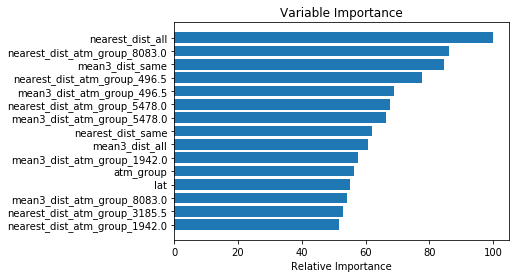

In [50]:
regr.fit(train[all_features].values, train_y)
plot_importance(regr, np.array(all_features))

Отбор фич можно было произвести с помощью https://github.com/scikit-learn-contrib/boruta_py или https://github.com/rasbt/mlxtend/blob/master/mlxtend/feature_selection/sequential_feature_selector.py

Ниже показан ещё один способ:

In [51]:
from sklearn.feature_selection import RFECV

In [55]:
selector = RFECV(regr, step=1, cv=3)

In [56]:
%%time

selector.fit(train[all_features].values, train_y)

Wall time: 15min 57s


RFECV(cv=3,
   estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=90, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [57]:
sum(selector.support_)

85

In [58]:
selected_features = all_features[selector.support_]

In [59]:
regr = LGBMRegressor(n_estimators=90)
-cross_val_score(regr, train[selected_features], train_y, cv=10, scoring=sqrt_mean_squared_error_scorer).mean()

0.044635495170901915

Однако во время соревнования фичи были подобраны вручную:

In [60]:
lgbm_features = ['lat', 'long', 'atm_group'] + atm_group_columns + subject_columns +\
    ['total_salary_per_atm_count'] + mean3_columns + nearest_columns

In [61]:
regr = LGBMRegressor(n_estimators=90)
-cross_val_score(regr, train[lgbm_features], train_y, cv=10, scoring=sqrt_mean_squared_error_scorer).mean()

0.044820750452441833

### Отбор выбросов

Попробуем уменьшить ошибку, перестав учитывать выбросы при обучении.

In [62]:
pred_train = cross_val_predict(estimator=regr, X=train[lgbm_features], y=train_y, cv=10)
abs_train_error = np.absolute(train_y - pred_train)

In [63]:
def masked_cross_val_score(regr, X, y, outlier_mask):
    r = []

    for train_val_index, val_index in KFold(n_splits=10).split(train_y):
        train_val_X, val_X = X.values[train_val_index], X.values[val_index]
        train_val_y, val_y = y[train_val_index], y[val_index]
        regr.fit(train_val_X[~outlier_mask[train_val_index]], train_val_y[~outlier_mask[train_val_index]])
        r.append(sqrt_mean_squared_error(val_y, regr.predict(val_X)))
        
    return np.mean(r)

In [64]:
from IPython.display import display, clear_output

In [65]:
limits = np.arange(0.075, 0.01, -0.001)
ms = []

for abs_train_error_limit in tqdm(limits):
    outlier_mask = (abs_train_error > abs_train_error_limit)
    ms.append(masked_cross_val_score(regr, train[lgbm_features], train_y, outlier_mask))
    clear_output(wait=True)
    display("abs_train_error_limit: {}, result: {}".format(abs_train_error_limit, ms[-1]))

'abs_train_error_limit: 0.01099999999999994, result: 0.04420851413865169'

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [03:31<00:00,  2.08s/it]


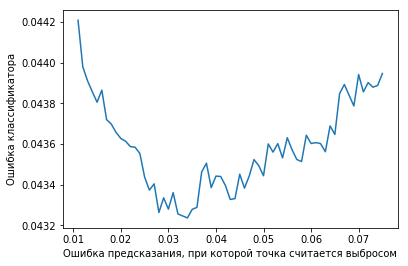

In [66]:
plt.xlabel("Ошибка предсказания, при которой точка считается выбросом")
plt.ylabel("Ошибка классификатора")
plt.plot(limits, ms);

In [67]:
best_limit = limits[np.argmin(ms)]
best_limit

0.03399999999999996

In [68]:
outlier_mask = (abs_train_error > best_limit)

regr = LGBMRegressor(n_estimators=90)
masked_cross_val_score(regr, train[lgbm_features], train_y, outlier_mask)

0.04323698247447099

Видим, что ошибка предсказания уменьшилась.

### Подбор гиперпараметров

Подберём теперь оптимальное число деревьев для бустинга:

In [69]:
estimators = np.arange(90, 800, 50)
ms = []

for n_estimators in tqdm(estimators):
    regr = LGBMRegressor(n_estimators=n_estimators)
    ms.append(masked_cross_val_score(regr, train[lgbm_features], train_y, outlier_mask))
    clear_output(wait=True)
    display("n_estimators: {}, result: {}".format(n_estimators, ms[-1]))

'n_estimators: 790, result: 0.042930309126496036'

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [03:23<00:00, 20.69s/it]


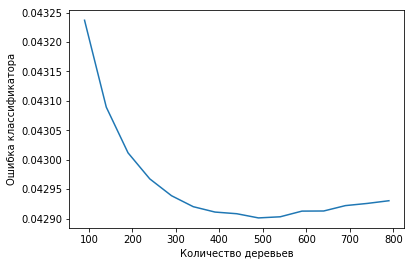

In [70]:
plt.xlabel("Количество деревьев")
plt.ylabel("Ошибка классификатора")
plt.plot(estimators, ms);

In [71]:
best_n_estimators = estimators[np.argmin(ms)]
best_n_estimators

490

In [72]:
regr = LGBMRegressor(n_estimators=best_n_estimators)
masked_cross_val_score(regr, train[lgbm_features], train_y, outlier_mask)

0.04290111176777265

Кстати, если бы был взят лучший набор фичей, ошибка была бы ещё меньше:

In [73]:
regr = LGBMRegressor(n_estimators=best_n_estimators)
masked_cross_val_score(regr, train[selected_features], train_y, outlier_mask)

0.04288994127807504

### Подготовка решения к отправке

In [74]:
regr.fit(train[lgbm_features].values[~outlier_mask], train_y[~outlier_mask])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=490, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [75]:
test["target"] = regr.predict(test[lgbm_features])

In [76]:
test[["target"]].to_csv("result14.csv")